In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CNN

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
data_path = '/content/drive/MyDrive/thesis all/thesis dataset'
img_size = (224, 224)
batch_size = 32

all_image_files = []
all_labels = []

for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_files.append(os.path.join(class_path, image_file))
                all_labels.append(class_folder)

train_files, test_files, train_labels, test_labels = train_test_split(
    all_image_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.1, random_state=29, stratify=train_labels
)

train_datagen = ImageDataGenerator(
    rescale=1./255,

)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_data_generator = val_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data_generator = val_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 712 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [ ]:

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data_generator,
    epochs=10,
    validation_data=val_data_generator
)

test_loss, test_accuracy = model.evaluate(test_data_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
23/23 [==============================] - 183s 8s/step - loss: 0.6660 - accuracy: 0.6390 - val_loss: 0.4843 - val_accuracy: 0.9125
Epoch 2/10
23/23 [==============================] - 172s 8s/step - loss: 0.4506 - accuracy: 0.8188 - val_loss: 0.3284 - val_accuracy: 0.8875
Epoch 3/10
23/23 [==============================] - 163s 7s/step - loss: 0.3506 - accuracy: 0.8890 - val_loss: 0.2701 - val_accuracy: 0.8750
Epoch 4/10
23/23 [==============================] - 172s 8s/step - loss: 0.3182 - accuracy: 0.8947 - val_loss: 0.2260 - val_accuracy: 0.9375
Epoch 5/10
23/23 [==============================] - 162s 7s/step - loss: 0.2688 - accuracy: 0.9073 - val_loss: 0.2018 - val_accuracy: 0.9250
Epoch 6/10
23/23 [==============================] - 163s 7s/step - loss: 0.2353 - accuracy: 0.9242 - val_loss: 0.1813 - val_accuracy: 0.9375
Epoch 7/10
23/23 [==============================] - 162s 7s/step - loss: 0.2315 - accuracy: 0.9143 - val_loss: 0.2132 - val_accuracy: 0.9000
Epoch 8/10
23

7/7 [==============================] - 43s 6s/step


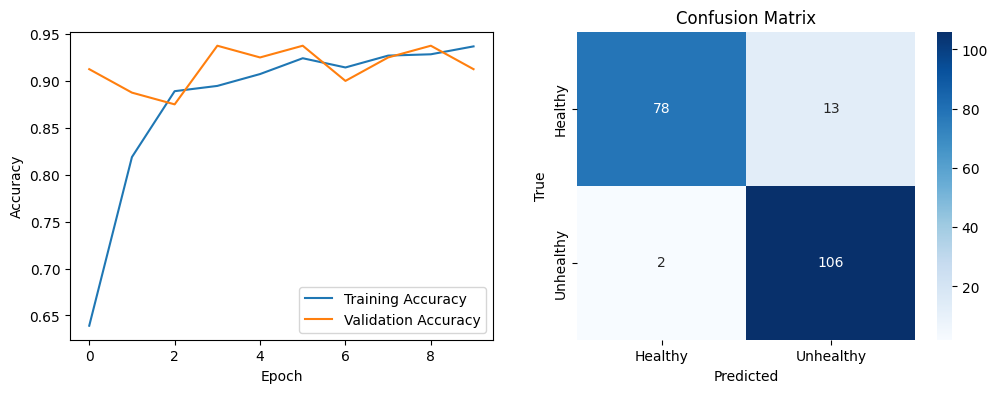


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.97      0.86      0.91        91
   Unhealthy       0.89      0.98      0.93       108

    accuracy                           0.92       199
   macro avg       0.93      0.92      0.92       199
weighted avg       0.93      0.92      0.92       199



In [ ]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
predictions = model.predict(test_data_generator)
y_true = test_data_generator.classes
y_pred = predictions.argmax(axis=-1)
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Unhealthy'], yticklabels=['Healthy', 'Unhealthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Unhealthy']))


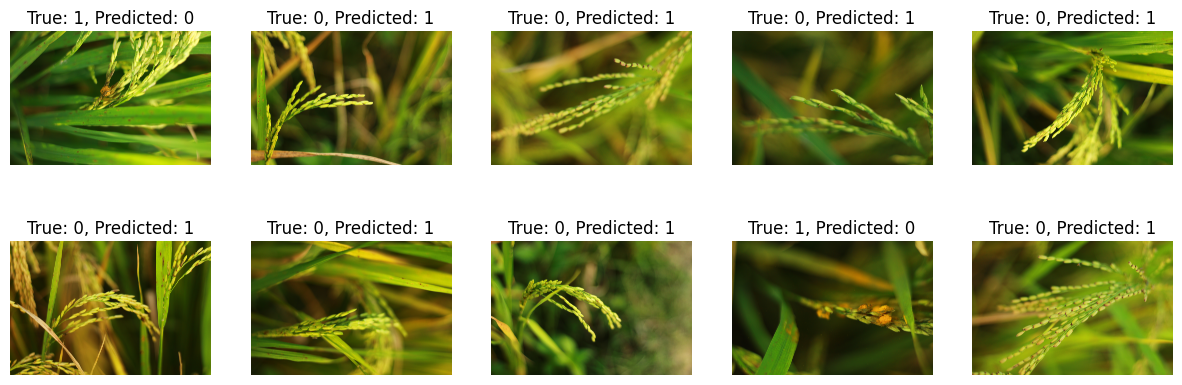

In [ ]:

misclassified_indices = np.where(y_true != y_pred)[0]
num_misclassified = len(misclassified_indices)

plt.figure(figsize=(15, 5))
for i, index in enumerate(misclassified_indices[:min(10, num_misclassified)], 1):
    plt.subplot(2, 5, i)
    img_path = test_data_generator.filepaths[index]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f'True: {test_data_generator.classes[index]}, Predicted: {y_pred[index]}')
    plt.axis('off')

plt.show()

WITH PREPROCESSING

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam



In [ ]:
data_path = '/content/drive/MyDrive/thesis all/thesis dataset'
img_size = (224, 224)
batch_size = 32



all_image_files = []
all_labels = []

for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_files.append(os.path.join(class_path, image_file))
                all_labels.append(class_folder)

train_files, test_files, train_labels, test_labels = train_test_split(
    all_image_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.1, random_state=29, stratify=train_labels
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_data_generator = val_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data_generator = val_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 712 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data_generator,
    epochs=10,
    validation_data=val_data_generator
)

train_accuracy = history.history['accuracy'][-1]
test_accuracy = model.evaluate(test_data_generator)[1]
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Epoch 1/10
23/23 [==============================] - 183s 8s/step - loss: 0.7112 - accuracy: 0.5927 - val_loss: 0.5179 - val_accuracy: 0.6250
Epoch 2/10
23/23 [==============================] - 175s 8s/step - loss: 0.4950 - accuracy: 0.7907 - val_loss: 0.3827 - val_accuracy: 0.9375
Epoch 3/10
23/23 [==============================] - 181s 8s/step - loss: 0.3975 - accuracy: 0.8834 - val_loss: 0.2810 - val_accuracy: 0.9250
Epoch 4/10
23/23 [==============================] - 168s 7s/step - loss: 0.3687 - accuracy: 0.8933 - val_loss: 0.2341 - val_accuracy: 0.9250
Epoch 5/10
23/23 [==============================] - 176s 8s/step - loss: 0.3325 - accuracy: 0.8722 - val_loss: 0.2075 - val_accuracy: 0.9375
Epoch 6/10
23/23 [==============================] - 174s 8s/step - loss: 0.3233 - accuracy: 0.8876 - val_loss: 0.2055 - val_accuracy: 0.9375
Epoch 7/10
23/23 [==============================] - 182s 8s/step - loss: 0.3060 - accuracy: 0.8975 - val_loss: 0.2331 - val_accuracy: 0.9125
Epoch 8/10
23

7/7 [==============================] - 46s 6s/step


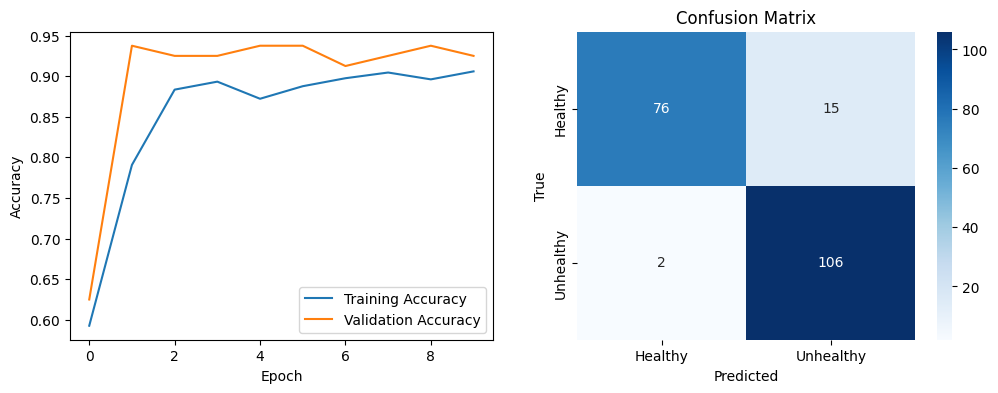


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.97      0.84      0.90        91
   Unhealthy       0.88      0.98      0.93       108

    accuracy                           0.91       199
   macro avg       0.93      0.91      0.91       199
weighted avg       0.92      0.91      0.91       199



In [ ]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
predictions = model.predict(test_data_generator)
y_true = test_data_generator.classes
y_pred = predictions.argmax(axis=-1)
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Unhealthy'], yticklabels=['Healthy', 'Unhealthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Unhealthy']))


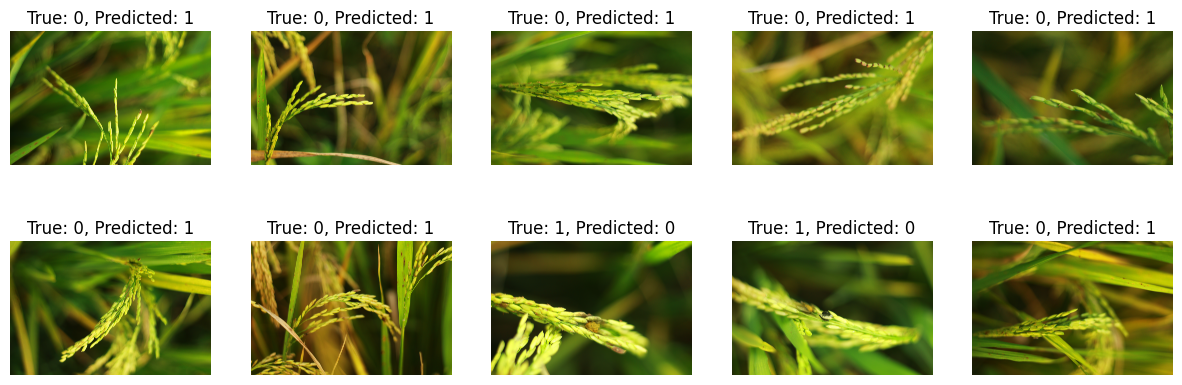

In [ ]:

misclassified_indices = np.where(y_true != y_pred)[0]
num_misclassified = len(misclassified_indices)

plt.figure(figsize=(15, 5))
for i, index in enumerate(misclassified_indices[:min(10, num_misclassified)], 1):
    plt.subplot(2, 5, i)
    img_path = test_data_generator.filepaths[index]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f'True: {test_data_generator.classes[index]}, Predicted: {y_pred[index]}')
    plt.axis('off')

plt.show()